# **<ins><center>RRI TUTORIAL</center></ins>**

This notebook provides a basic overview and information on how to use the CASSIOPE RRI HDF5 files to plot a spectrogram for each dipole.

### <ins>Table of Contents</ins>

* [About RRI](#about-rri)
* [Prerequisites](#prerequisites)
* [How the RRI files are stored](#how-the-files-are-stored)
* [Tutorials](#tutorials)
    1. [Creating a Spectrogram](#creating-a-spectrogram)
    2. [Reading RRI HDF5 Files](#reading-rri-hdf5-files)
    3. [Preprocessing Data](#preprocessing-data)
    4. [Calculating FFTs](#calculating-ffts)
    5. [Plotting Spectrogram](#plotting-spectrogram)
    6. [Plotting Spectrogram for Channel B](#plotting-spectrogram-for-channel-b)

<a id="about-rri"></a>

### <ins>About RRI</ins>

The Radio Receiver Instrument (RRI) is a four-channel digital receiver fed by four 3-metre monopoles called radio monopoles 1-4, arranged in a crossed configuration. The receiver measures the electric fields of either spontaneous radio emissons or waves created by ground transmitters, such as ionosondes, high-frequency radars ad ionospheric heaters. RRI has a sampling rate of 65200.33933 Hz and monopoles 1 and 2 are part of channel A, and monopoles 3 and 4 make up channel B. This is done to operate channel A on one frequency and channel B on another, or both on the same. The vast majority of the time instrument is operated in its "I3-Q1-I3-Q3" mode where monopoles 1 and 3 are the real components(l-component) and monopoles 2 and 4 are the complex components (Q-component). The data is downloaded to the ground station in 256 byte packets, with each packet containing 29 samples from each monopole. 

You can find the open-access RRI instrument paper __[here](https://link.springer.com/article/10.1007/s11214-014-0130-y)__. 

<a id="prerequisites"></a>

### <ins>Prerequisites</ins>

1. This tutorial assumes you have some basic understanding of Python and its terminology.

2. You will be required to install the following libraries in your python environment:
    *  __[h5py](https://docs.h5py.org/en/stable/)__
    *  __[numpy](https://numpy.org/install/)__
    *  __[matplotlib](https://matplotlib.org/stable/users/installing/index.html)__

3. To plot a spectrogram, it will be beneficial to have some basic understanding of Fast Fourier Transform (FFT) and the normalization techniques used for spectrograms. 

<a id="how-the-files-are-stored"></a>

### <ins>How the files are stored</ins>

The level 1 files from RRI are stored in *zip* format. The *zip* files contain an *H5* file from a given pass. Each *H5* file contains three datasets:

* CASSIOPE Ephemeris: This dataset contains information about the spacecraft's telemetry such as sltitude, Mission Elapsed Time (MET), position, velocity, etc.  

* RRI Data: This dataset contains channel A and B frequencies along with data collected from the two dipoles (Dipole A: Monopole 1,2 Dipole B: Monopole 3,4)

* RRI Settings: Information regarding RRI settings are stored within this dataset, for example the antenna gains, dwell times, sweep modes, etc. 

For information about the attributes of each dataset please visit __https://epop.phys.ucalgary.ca/data-handbook/rri-lv1-hdf-file/__ or contact __esoc@phys.ucalgary.ca__

<a id="tutorials"></a>

## **<ins><center>Tutorials</center></ins>**

<a id="creating-a-spectrogram"></a>

### <ins>Creating a Spectrogram</ins>

This section describes one way of plotting a spectrogram for RRI data. The data from RRI is sent to the ground station in 256 byte packets with each packet containing 29 samples from each monopole. RRI may be operated in a fixed-frequency mode, where the radio is tuned to a single frequency, or in a sweep mode where the tuning frequency changes with time. For simplicity, in this tutorial we will be dealing with data from files that have a fixed frequency. Also, for time values it has been found that the RRI crystal oscillator is extremely stable, so, we take the time from the first RRI packet and extrapolate that to the end of the pass and get the time values for all samples. 

The input time-domain signal, is transformed into the frequency domain for a spectrogram using Fast Fourier Transform, and describes what frequencies were present in that signal. However, one downside of this process is that we lose all information about when the frequencies occurred. A common way to counteract with this issue is to divide the signal into *N* parts (typically with *N* having small prime factors), calculate the FFT of all parts and plot them in the order that they appeared in. This way we can save some information about when a frequency occurred and not all time-domain data is lost. A higher time resolution results in knowing when each FFT occurred but provides imprecise frequency information, whereas high frequency resolution sharpens peaks on each FFT but degrades time resolution. So, in the end depending on your needs, it is all about finding a "sweet-spot". The RRI quicklook plots on __https://epop-data.phys.ucalgary.ca__ use 5208 as the default "N" value.

<a id="reading-rri-hdf5-files"></a>

#### <ins>Reading RRI HDF5 files</ins>

To read RRI *h5* files, we will be using the functionality of python's *h5py* package. Here we are using the file from __[2017/02/01](https://epop-data.phys.ucalgary.ca/2017/02/01/RRI/RRI_20170201_081043_081555_lv1_13.1.1.h5.zip)__, but the process for creating a spectrogram should work the same for any other file.

NOTE: Please make sure to extract the *h5* file to your current working directory to run the following code without any issues.  

In [1]:
import h5py                         #for retrieving data from h5 files 
import numpy as np                  #for dealing with arrays

#name of h5 file to be read 
h5_File = "RRI_20170201_081043_081555_lv1_13.1.1.h5"


"""Opening the h5 file and 
copying the relevant data into objects"""
with h5py.File(h5_File, "r") as file:
    
    print(file.keys())

    #channel A frequency value
    Freq_A = np.array(file["RRI Data"]["Channel A Frequencies (Hz)"]).flatten()[0]

    #Dipole A data
    Monopole_1 = np.array(file['RRI Data']['Radio Data Monopole 1 (mV)']).flatten()
    Monopole_2 = np.array(file['RRI Data']['Radio Data Monopole 2 (mV)']).flatten()

    #time value from first packet
    time_0 = np.array(file['CASSIOPE Ephemeris']['Ephemeris MET (seconds since May 24, 1968)'])[0]


<KeysViewHDF5 ['CASSIOPE Ephemeris', 'RRI Data', 'RRI Settings']>


In the above code snippet, we first open the *h5* file from 2017/02/01 and copy the relevant information into python objects. *Freq_A* contains channel A frequency, *Monopole_X* contains information about the signal in millivolts (mV) and *time_0* contains the seconds elapsed since May 24, 1968 when the first reading was taken. *Monopole_X*'s are flattened because the data is in a 2 dimensional array with each row containing 29 samples from each monopole. 

<a id="preprocessing-data"></a>

#### <ins>Preprocessing Data</ins>

With the relevant data in Python objects, we can move onto the preprocessing step. Here we will convert the data from millivolts (mV) to microvolts ($\mu V$) and create an array containing the times when the sample was collected. We will also be initialising some constants.

In [2]:
#sampling frequency of RRI
SAMPLING_FREQ = 62500.33933

#number of samples to be used for FFT calculation
NUM_SAMPLES = 5208

#converting millivolts to microvolts
Monopole_1 = Monopole_1*1E3
Monopole_2 = Monopole_2*1E3

"""combining Dipole A into a complex representation with
Monopole 1 as the real part
Monopole 2 as the imaginary part""" 
"""This assumes that the instrument is run in its 
"I1-Q1-I3-Q3" mode, which it is for the vast 
majority of the mission"""
Dipole_A = Monopole_1 + 1j*Monopole_2

#array containing times for each sample
time_array = np.arange(0, Monopole_1.shape[0])/SAMPLING_FREQ + time_0

<a id="calculating-ffts"></a>

#### <ins>Calculating FFTs</ins>

The following snippet calculates FFT of the signal, average of times and the frequency bins. For an in-depth explanation, refer to the comments.  

In [3]:
#empty list to contain FFT of signal samples
FFT_list = []

#empty list to contain average of time values
time_list = []

#Blackman-Harris Filter to reduce spectral leakage
a0 = 0.3635819
a1 = 0.4891775
a2 = 0.1365995
a3 = 0.0106411
var = np.pi * np.arange(NUM_SAMPLES) / (NUM_SAMPLES - 1)
bh_fil = a0 - a1 * np.cos(2 * var) + a2 * np.cos(4 * var) - a3 * np.cos(6 * var)


#index variable for while loop
i=0

"""loop for calculating FFT from 
i to i+NUM_SAMPLES elements of the signal.
With each iteration i increases by NUM_SAMPLES"""
while i<(Dipole_A.shape[0]-NUM_SAMPLES):
    
    #samples of the signal from i to i+NUM_SAMPLES
    #multiplying with bh_fil to prevent spectral leakage
    x = Dipole_A[i:i+NUM_SAMPLES]*bh_fil

    #calculating FFT for x
    #dividing by NUM_SAMPLES for normalization
    x_FFT = np.real(np.fft.fftshift(np.fft.fft(x, n=NUM_SAMPLES))) / NUM_SAMPLES

    #scaling x_FFT
    Pxx = 20*np.log10(np.absolute(x_FFT))

    #appending data to corresponding list
    FFT_list.append(Pxx)


    #calculating average time for the current signal sample
    #and adding it to its respective list
    avg_time = np.average(time_array[i:i+NUM_SAMPLES])
    time_list.append(avg_time)


    #iterating i for next run of the loop
    i = i + NUM_SAMPLES


#converting FFT_list to an array for better performance
FFT_array = np.array(FFT_list)
#taking transpose to properly align the array
FFT_array = FFT_array.T
#slicing the array to include only the relevant portion 
"""this step would slice out the first NUM_SAMPLES/4 rows 
the last (3*NUM_SAMPLES)/4 rows. The slicing indexes were
decided by RRI calibration methods"""
FFT_array = FFT_array[int(NUM_SAMPLES/4):int(3*NUM_SAMPLES/4)]


#converting time list to an array and 
#slicing it to have the correct shape based on FFT_array
Time_avg = np.array(time_list)
Time_avg = Time_avg[0:int(FFT_array.shape[1])]


#getting frequency bins to be plotted on y-axis
Freq_bins = np.fft.fftfreq(NUM_SAMPLES, d=1.0/SAMPLING_FREQ)

#Scaling frequency bins such that the channel frequency is at the center 
Freq_bins = Freq_bins - SAMPLING_FREQ/4 + Freq_A

#Converting frequency bins from Hz to MHz
Freq_bins = Freq_bins/1E6

#Slicing freqency bins to have the same shape as FFT_array
Freq_bins = Freq_bins[0:int(FFT_array.shape[0])]

<a id="plotting-spectrogram"></a>

#### <ins>Plotting Spectrogram</ins>

The following snippet describes how to plot a spectrogram.

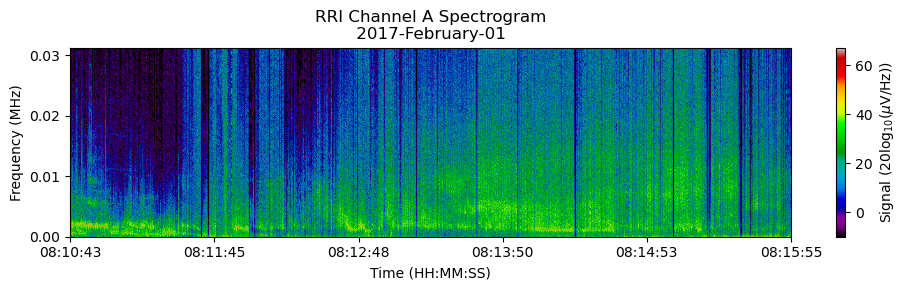

In [4]:
import matplotlib.pyplot as plt             #for plotting spectrogram
from matplotlib.colors import Normalize     #for normalizing colorbar
import datetime as dt                       #for dealing with datetime values

"""Since this is a scatter plot we will need to 
flatten FFT_array and create two more arrays for
frequency and time values"""

Time_scatter = np.full((FFT_array.shape[0], FFT_array.shape[1]), Time_avg).flatten("F")
Freq_scatter = np.full((FFT_array.shape[1], FFT_array.shape[0]), Freq_bins).flatten()
FFT_scatter = FFT_array.flatten("F")

#objects to be used for Matplotlib graph

#Normalizing max, min values of FFT for colorbar
a_max = np.nanmax(FFT_scatter)
a_min = np.nanmin(FFT_scatter)

if a_min<0:
    a_min = -10

signal_norm = Normalize(vmin=a_min, vmax=a_max)

#plotting spectrogram 
fig, ax = plt.subplots(figsize = (10,3))
RRI_channel_plot = ax.scatter(Time_scatter, Freq_scatter, c=FFT_scatter,
                              norm=signal_norm, cmap="nipy_spectral",
                              s=0.2)

#setting title 
title_date = dt.datetime.strptime("1968-05-24 00:00:00", '%Y-%m-%d %H:%M:%S') + dt.timedelta(seconds=Time_scatter[0])
title_date = dt.datetime.strftime(title_date, ' %Y-%B-%d ')
ax.set_title('RRI Channel A Spectrogram\n' + title_date)

#Set plot height
freq_max = np.nanmax(Freq_scatter)
freq_min = np.nanmin(Freq_scatter)
ax.set_ybound(lower=freq_min, upper=freq_max)

#Set plot width
start_time = Time_scatter[0]
end_time = Time_scatter[-1]
ax.set_xbound(lower=start_time, upper=end_time)

#Set plot x-ticks
xticks = np.linspace(start_time, end_time, num=6)
datetime_labels = []
for time in xticks:
    utc = dt.datetime.strptime("1968-05-24 00:00:00", '%Y-%m-%d %H:%M:%S') + dt.timedelta(seconds=time)
    datetime_labels.append(dt.datetime.strftime(utc, '%H:%M:%S'))
ax.set_xticks(xticks, labels=datetime_labels)

# Add colorbar
cbar = fig.colorbar(RRI_channel_plot, cmap='nipy_spectral', ax = ax)
cbar.set_label(r"Signal (20log$_{10}$($\mu$V/Hz))")

#Add x and y labels
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Frequency (MHz)")

#display plot
plt.tight_layout()
plt.show()

<a id="plotting-spectrogram-for-channel-b"></a>

### <ins>Plotting Spectrogram for Channel B</ins>

To plot a spectrogram for channel B, we will need to follow the same steps as we did for channel A but replace the radio monopoles 1 and 2 with monopoles 3 and 4. Following is the complete code: 

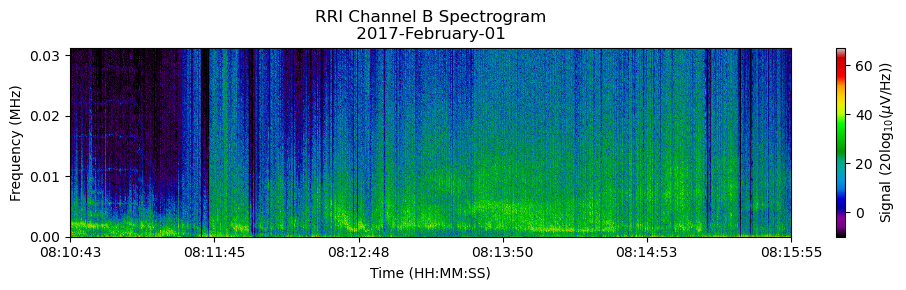

In [6]:
import h5py                                 #for retrieving data from h5 files 
import numpy as np                          #for dealing with arrays
import matplotlib.pyplot as plt             #for plotting spectrogram
from matplotlib.colors import Normalize     #for normalizing colorbar
import datetime as dt                       #for dealing with datetime values

#name of h5 file to be read 
h5_File = "RRI_20170201_081043_081555_lv1_13.1.1.h5"

#sampling frequency of RRI
SAMPLING_FREQ = 62500.33933

#number of samples to be used for FFT calculation
NUM_SAMPLES = 5208


"""Opening the h5 file and 
copying the relevant data into objects"""
with h5py.File(h5_File, "r") as file:

    #channel B frequency value
    Freq_B = np.array(file["RRI Data"]["Channel B Frequencies (Hz)"]).flatten()[0]

    #Dipole B data
    Monopole_3 = np.array(file['RRI Data']['Radio Data Monopole 3 (mV)']).flatten()
    Monopole_4 = np.array(file['RRI Data']['Radio Data Monopole 4 (mV)']).flatten()

    #time value from first packet
    time_0 = np.array(file['CASSIOPE Ephemeris']['Ephemeris MET (seconds since May 24, 1968)'])[0]


#PREPROCESSING

#converting millivolts to microvolts
Monopole_3 = Monopole_3*1E3
Monopole_4 = Monopole_4*1E3

"""combining Dipole B into a complex representation with
Monopole 3 as the real part
Monopole 4 as the imaginary part""" 
"""This assumes that the instrument is run in its 
"I1-Q1-I3-Q3" mode, which it is for the vast 
majority of the mission"""
Dipole_B = Monopole_3 + 1j*Monopole_4

#array containing times for each sample
time_array = np.arange(0, Monopole_3.shape[0])/SAMPLING_FREQ + time_0


#CALCULATING FFTs

#empty list to contain FFT of signal samples
FFT_list = []

#empty list to contain average of time values
time_list = []

#Blackman-Harris Filter to reduce spectral leakage
a0 = 0.3635819
a1 = 0.4891775
a2 = 0.1365995
a3 = 0.0106411
var = np.pi * np.arange(NUM_SAMPLES) / (NUM_SAMPLES - 1)
bh_fil = a0 - a1 * np.cos(2 * var) + a2 * np.cos(4 * var) - a3 * np.cos(6 * var)


#index variable for while loop
i=0

"""loop for calculating FFT from 
i to i+NUM_SAMPLES elements of the signal.
With each iteration i increases by NUM_SAMPLES"""
while i<(Dipole_B.shape[0]-NUM_SAMPLES):
    
    #samples of the signal from i to i+NUM_SAMPLES
    #multiplying with bh_fil to prevent spectral leakage
    x = Dipole_B[i:i+NUM_SAMPLES]*bh_fil

    #calculating FFT for x
    #dividing by NUM_SAMPLES for normalization
    x_FFT = np.real(np.fft.fftshift(np.fft.fft(x, n=NUM_SAMPLES))) / NUM_SAMPLES

    #scaling x_FFT
    Pxx = 20*np.log10(np.absolute(x_FFT))

    #appending data to corresponding list
    FFT_list.append(Pxx)


    #calculating average time for the current signal sample
    #and adding it to its respective list
    avg_time = np.average(time_array[i:i+NUM_SAMPLES])
    time_list.append(avg_time)


    #iterating i for next run of the loop
    i = i + NUM_SAMPLES


#converting FFT_list to an array for better performance
FFT_array = np.array(FFT_list)
#taking transpose to properly align the array
FFT_array = FFT_array.T
#slicing the array to include only the relevant portion 
"""this step would slice out the first NUM_SAMPLES/4 rows 
the last (3*NUM_SAMPLES)/4 rows. The slicing indexes were
decided by RRI calibration methods"""
FFT_array = FFT_array[int(NUM_SAMPLES/4):int(3*NUM_SAMPLES/4)]


#converting time list to an array and 
#slicing it to have the correct shape based on FFT_array
Time_avg = np.array(time_list)
Time_avg = Time_avg[0:int(FFT_array.shape[1])]


#getting frequency bins to be plotted on y-axis
Freq_bins = np.fft.fftfreq(NUM_SAMPLES, d=1.0/SAMPLING_FREQ)

#Scaling frequency bins such that the channel frequency is at the center 
Freq_bins = Freq_bins - SAMPLING_FREQ/4 + Freq_B

#Converting frequency bins from Hz to MHz
Freq_bins = Freq_bins/1E6

#Slicing freqency bins to have the same shape as FFT_array
Freq_bins = Freq_bins[0:int(FFT_array.shape[0])]


#PLOTTING SPECTROGRAM

"""Since this is a scatter plot we will need to 
flatten FFT_array and create two more arrays for
frequency and time values"""

Time_scatter = np.full((FFT_array.shape[0], FFT_array.shape[1]), Time_avg).flatten("F")
Freq_scatter = np.full((FFT_array.shape[1], FFT_array.shape[0]), Freq_bins).flatten()
FFT_scatter = FFT_array.flatten("F")

#objects to be used for Matplotlib graph

#Normalizing max, min values of FFT for colorbar
a_max = np.nanmax(FFT_scatter)
a_min = np.nanmin(FFT_scatter)

if a_min<0:
    a_min = -10

signal_norm = Normalize(vmin=a_min, vmax=a_max)

#plotting spectrogram 
fig, ax = plt.subplots(figsize = (10,3))
RRI_channel_plot = ax.scatter(Time_scatter, Freq_scatter, c=FFT_scatter,
                              norm=signal_norm, cmap="nipy_spectral",
                              s=0.2)

#setting title 
title_date = dt.datetime.strptime("1968-05-24 00:00:00", '%Y-%m-%d %H:%M:%S') + dt.timedelta(seconds=Time_scatter[0])
title_date = dt.datetime.strftime(title_date, ' %Y-%B-%d ')
ax.set_title('RRI Channel B Spectrogram\n' + title_date)

#Set plot height
freq_max = np.nanmax(Freq_scatter)
freq_min = np.nanmin(Freq_scatter)
ax.set_ybound(lower=freq_min, upper=freq_max)

#Set plot width
start_time = Time_scatter[0]
end_time = Time_scatter[-1]
ax.set_xbound(lower=start_time, upper=end_time)

#Set plot x-ticks
xticks = np.linspace(start_time, end_time, num=6)
datetime_labels = []
for time in xticks:
    utc = dt.datetime.strptime("1968-05-24 00:00:00", '%Y-%m-%d %H:%M:%S') + dt.timedelta(seconds=time)
    datetime_labels.append(dt.datetime.strftime(utc, '%H:%M:%S'))
ax.set_xticks(xticks, labels=datetime_labels)

# Add colorbar
cbar = fig.colorbar(RRI_channel_plot, cmap='nipy_spectral', ax = ax)
cbar.set_label(r"Signal (20log$_{10}$($\mu$V/Hz))")

#Add x and y labels
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Frequency (MHz)")

#display plot
plt.tight_layout()
plt.show()